In [1]:
from os import mkdir
from pathlib import Path

import brightway2 as bw
import bw2calc as bc
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from textwrap import wrap
from project_path import ROOT_DIR

plt.style.use("default")


In [2]:
bw.projects
bw.projects.set_current("GAC_project")
bw.databases

Databases dictionary with 3 object(s):
	GAC_project_db
	biosphere3
	ei39cutoff

In [3]:
ipcc_methods = [
    met
    for met in bw.methods
    if "ipcc 2021" in str(met).lower()
    and "climate change: including SLCFs" in str(met)
    and "no LT" not in str(met)
    and "GWP100" in str(met)
    or ("ipcc 2013" in str(met).lower() and "no LT" not in str(met) and "GWP100" in str(met))
    # or ("ipcc 2021" in str(met).lower() and "no LT" not in str(met) and "GWP100" in str(met))
][1]# [:2]
ipcc_methods


('IPCC 2021',
 'climate change: including SLCFs',
 'global warming potential (GWP100)')

In [4]:
DB_NAME = "GAC_project_db"

In [5]:
hetero_system = [
    ds
    for ds in bw.Database(DB_NAME)
    if "1-(naphthalen-1-yl)-1H-imidazole" in ds["name"] and "Cu/PCN" in ds["name"]
][0]
hetero_system

'1-(naphthalen-1-yl)-1H-imidazole production with heterogeneous Cu/PCN catalyst (10.8 wt% Cu)' (kilogram, GLO, None)

In [6]:
homoge_system = [
    ds
    for ds in bw.Database(DB_NAME)
    if "1-(naphthalen-1-yl)-1H-imidazole" in ds["name"]
    and "Cu2O/Altman-Buchwald-ligand" in ds["name"]
][0]
homoge_system

'1-(naphthalen-1-yl)-1H-imidazole production with homogeneous Cu2O/Altman-Buchwald-ligand catalytic complex' (kilogram, GLO, None)

In [7]:
bw.calculation_setups

CalculationSetups dictionary with 5 object(s):
	catalysts_only
	contrib
	solveLCA
	solveLCA_scenarios
	trial

In [8]:
def do_recursive_calculation(
    activity,
    lcia_method,
    lca_obj=None,
    total_score=None,
    amount=1,
    level=0,
    max_level=3,
    cutoff=1e-2,
):
    """ "Adapted from https://github.com/brightway-lca/brightway2/blob/master/notebooks/Contribution%20analysis%20and%20comparison.ipynb"""

    results = list()

    def get_lca_attributes(activity, lcia_method):
        result_item = dict()
        result_item["database"] = activity["database"]
        result_item["activity name"] = activity["name"]
        result_item["reference product"] = activity["reference product"]
        result_item["unit"] = activity["unit"]
        result_item["location"] = activity["location"]
        result_item[" - ".join(lcia_method) + f' ({bw.Method(lcia_method).metadata["unit"]})'] = lca_obj.score
        return result_item

    if lca_obj is None:
        lca_obj = bc.LCA({activity: amount}, lcia_method)
        lca_obj.lci()
        lca_obj.lcia()
        total_score = lca_obj.score
    elif total_score is None:
        raise ValueError
    else:
        lca_obj.redo_lcia({activity: amount})
        if abs(lca_obj.score) <= abs(total_score * cutoff):
            return

    results.append(get_lca_attributes(activity, lcia_method))

    if level < max_level:
        for exc in activity.technosphere():
            res = (
                do_recursive_calculation(
                    activity=exc.input,
                    lcia_method=lcia_method,
                    lca_obj=lca_obj,
                    total_score=total_score,
                    amount=amount * exc["amount"],
                    level=level + 1,
                    max_level=max_level,
                    cutoff=cutoff,
                )
            )
            results.append(res[0])
            
    return results

In [11]:
res_hetero = pd.DataFrame(
    do_recursive_calculation(
        activity=hetero_system, lcia_method=ipcc_methods, level=1, max_level=2
    )
)
# res_hetero
res_hetero_plot = res_hetero.iloc[1:, [2, 5]]
res_hetero_plot


,reference product,IPCC 2021 - climate change: including SLCFs - global warming potential (GWP100) (kg CO2-Eq)
1,1-iodonaphthalene,2.163055
2,imidazole,2.729986
3,Cu/PCN catalyst (10.8 wt% Cu),0.402700
4,dimethyl sulfoxide,0.314026


In [13]:
res_homoge = pd.DataFrame(
    do_recursive_calculation(
        activity=homoge_system, lcia_method=ipcc_methods, level=1, max_level=2
    )
)
# res_homoge
res_homoge_plot = res_homoge.iloc[1:, [2, 5]]
res_homoge_plot

,reference product,IPCC 2021 - climate change: including SLCFs - global warming potential (GWP100) (kg CO2-Eq)
1,1-iodonaphthalene,2.002083
2,imidazole,2.526824
3,Cu2O/Altman-Buchwald-ligand catalytic complex,54.210020
4,N-methyl-2-pyrrolidone,11.593745


In [14]:
pngFilesDir = Path(ROOT_DIR, r"data/interim/png_files") # full path to folder w/png files
svgFilesDir = Path(ROOT_DIR, r"data/interim/svg_files") # full path to folder w/svg files

# Generate required folders if needed
if not Path.exists(pngFilesDir):
    mkdir(pngFilesDir)
if not Path.exists(svgFilesDir):
    mkdir(svgFilesDir)

Preliminary colors:<br>

<b style="background-color: #ef8a62;">heterogeneous</b><br>  
<b style="background-color: #67a9cf;">homogeneous</b><br>

Sequence hetero:<br>
<b style="background-color: #ea7a52;">...1</b><br>
<b style="background-color: #ea987a;">...2</b><br>
<b style="background-color: #e4b6a6;">...3</b><br>
<b style="background-color: #dec8c0;">...4</b><br>

Sequence homo:<br>
<b style="background-color: #459fcc;">...1</b><br>
<b style="background-color: #7eb1cc;">...2</b><br>
<b style="background-color: #adc4cc;">...3</b><br>
<b style="background-color: #c2cecb;">...4</b><br>

In [15]:
## Doughnut CHART colors

allcolors = {
    "heterogeneous": "#ef8a62",
    "homogeneous": "#67a9cf",
}

hetero_colors = ["#ea7a52", "#ea987a", "#e4b6a6", "#dec8c0"]
homoge_colors = ["#459fcc", "#7eb1cc", "#adc4cc", "#c2cecb"]

In [16]:
def plot_doughnut(ax, data, explode, colors, startangle, tot_loc = (0.45, 0.47)):
    
    radius = 0.6
    
    def label_w_value(label, val, allvals):
        pct = np.round(val / np.sum(allvals) * 100, 2)
        absolute = np.round(val, 2)
        return "{:s}\n{:.1f}% ({:.2f})".format(label, pct, absolute)
    
    def value_as_label(val, allvals):
        pct = np.round(val / np.sum(allvals) * 100, 2)
        absolute = np.round(val, 2)
        return "{:.1f}% ({:.2f})".format(pct, absolute)

    # wedges, texts, autotexts = ax.pie(
    wedges, texts = ax.pie(
        data,
        explode=explode,
        colors=colors,
        # autopct=lambda pct: func(pct, data),
        # pctdistance=1.2,
        wedgeprops=dict(width=0.3),
        startangle=startangle,
        radius=radius,
    )

    # bbox_props = dict(boxstyle="round4,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(
        arrowprops=dict(arrowstyle="-"),
        # bbox=bbox_props,
        zorder=0,
        va="center",
        size=6,
    )

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2.0 + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(
            # label_w_value(labels[i], data[i], data),
            value_as_label(data[i], data),
            xy=(x*radius, y*radius),
            xytext=(x * np.sign(x), y),
            horizontalalignment=horizontalalignment,
            **kw
        )

    # total value in the center
    ax.text(
        x=tot_loc[0],
        y=tot_loc[1],
        s=np.round(np.sum(data), 1),
        transform=ax.transAxes,
        fontdict=dict(fontsize=7, fontweight="bold"),
    )
    return wedges, texts


In [17]:
labels_hetero = res_hetero_plot["reference product"].values.tolist()
data_hetero = res_hetero_plot.iloc[:, 1].values.tolist()
explode_hetero = (0, 0, 0.1, 0)

labels_homoge = res_homoge_plot["reference product"].values.tolist()
data_homoge = res_homoge_plot.iloc[:, 1].values.tolist()
explode_homoge = (0, 0, 0.1, 0)

category_label = "\n".join(wrap(res_hetero_plot.columns[1], 36))

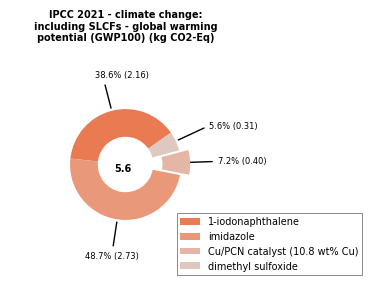

In [18]:
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

w, t = plot_doughnut(
    ax=ax,
    data=data_hetero,
    # labels=labels,
    explode=explode_hetero,
    colors=hetero_colors,
    startangle=35,
)
    
# legend
leg = ax.legend(w, labels_hetero,
        # title="Inputs:",
        loc="lower left",
        frameon=True,
        fancybox=False,
        edgecolor="k",
        # columnspacing=0.7,
        fontsize=7,
        bbox_to_anchor=(0.7, 0))

leg.get_frame().set_linewidth(0.4)
ax.set_title(
    category_label, fontdict=dict(fontsize=7, fontweight="bold"))

# plt.setp(at, size=7, weight="normal")
plt.show()


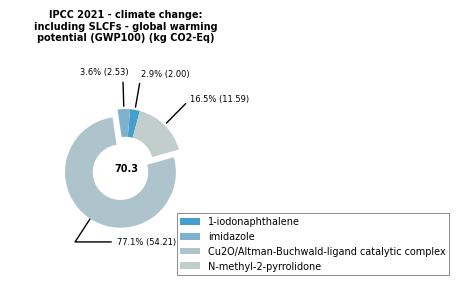

In [19]:
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

w, t = plot_doughnut(
    ax=ax,
    data=data_homoge,
    # labels=labels,
    explode=explode_homoge,
    colors=homoge_colors,
    startangle=75
)
    
# legend
leg = ax.legend(w, labels_homoge,
        # title="Inputs:",
        loc="lower left",
        frameon=True,
        fancybox=False,
        edgecolor="k",
        # columnspacing=0.7,
        fontsize=7,
        bbox_to_anchor=(0.7, 0))

leg.get_frame().set_linewidth(0.4)
ax.set_title(
    category_label, fontdict=dict(fontsize=7, fontweight="bold"))

# plt.setp(at, size=7, weight="normal")
plt.show()


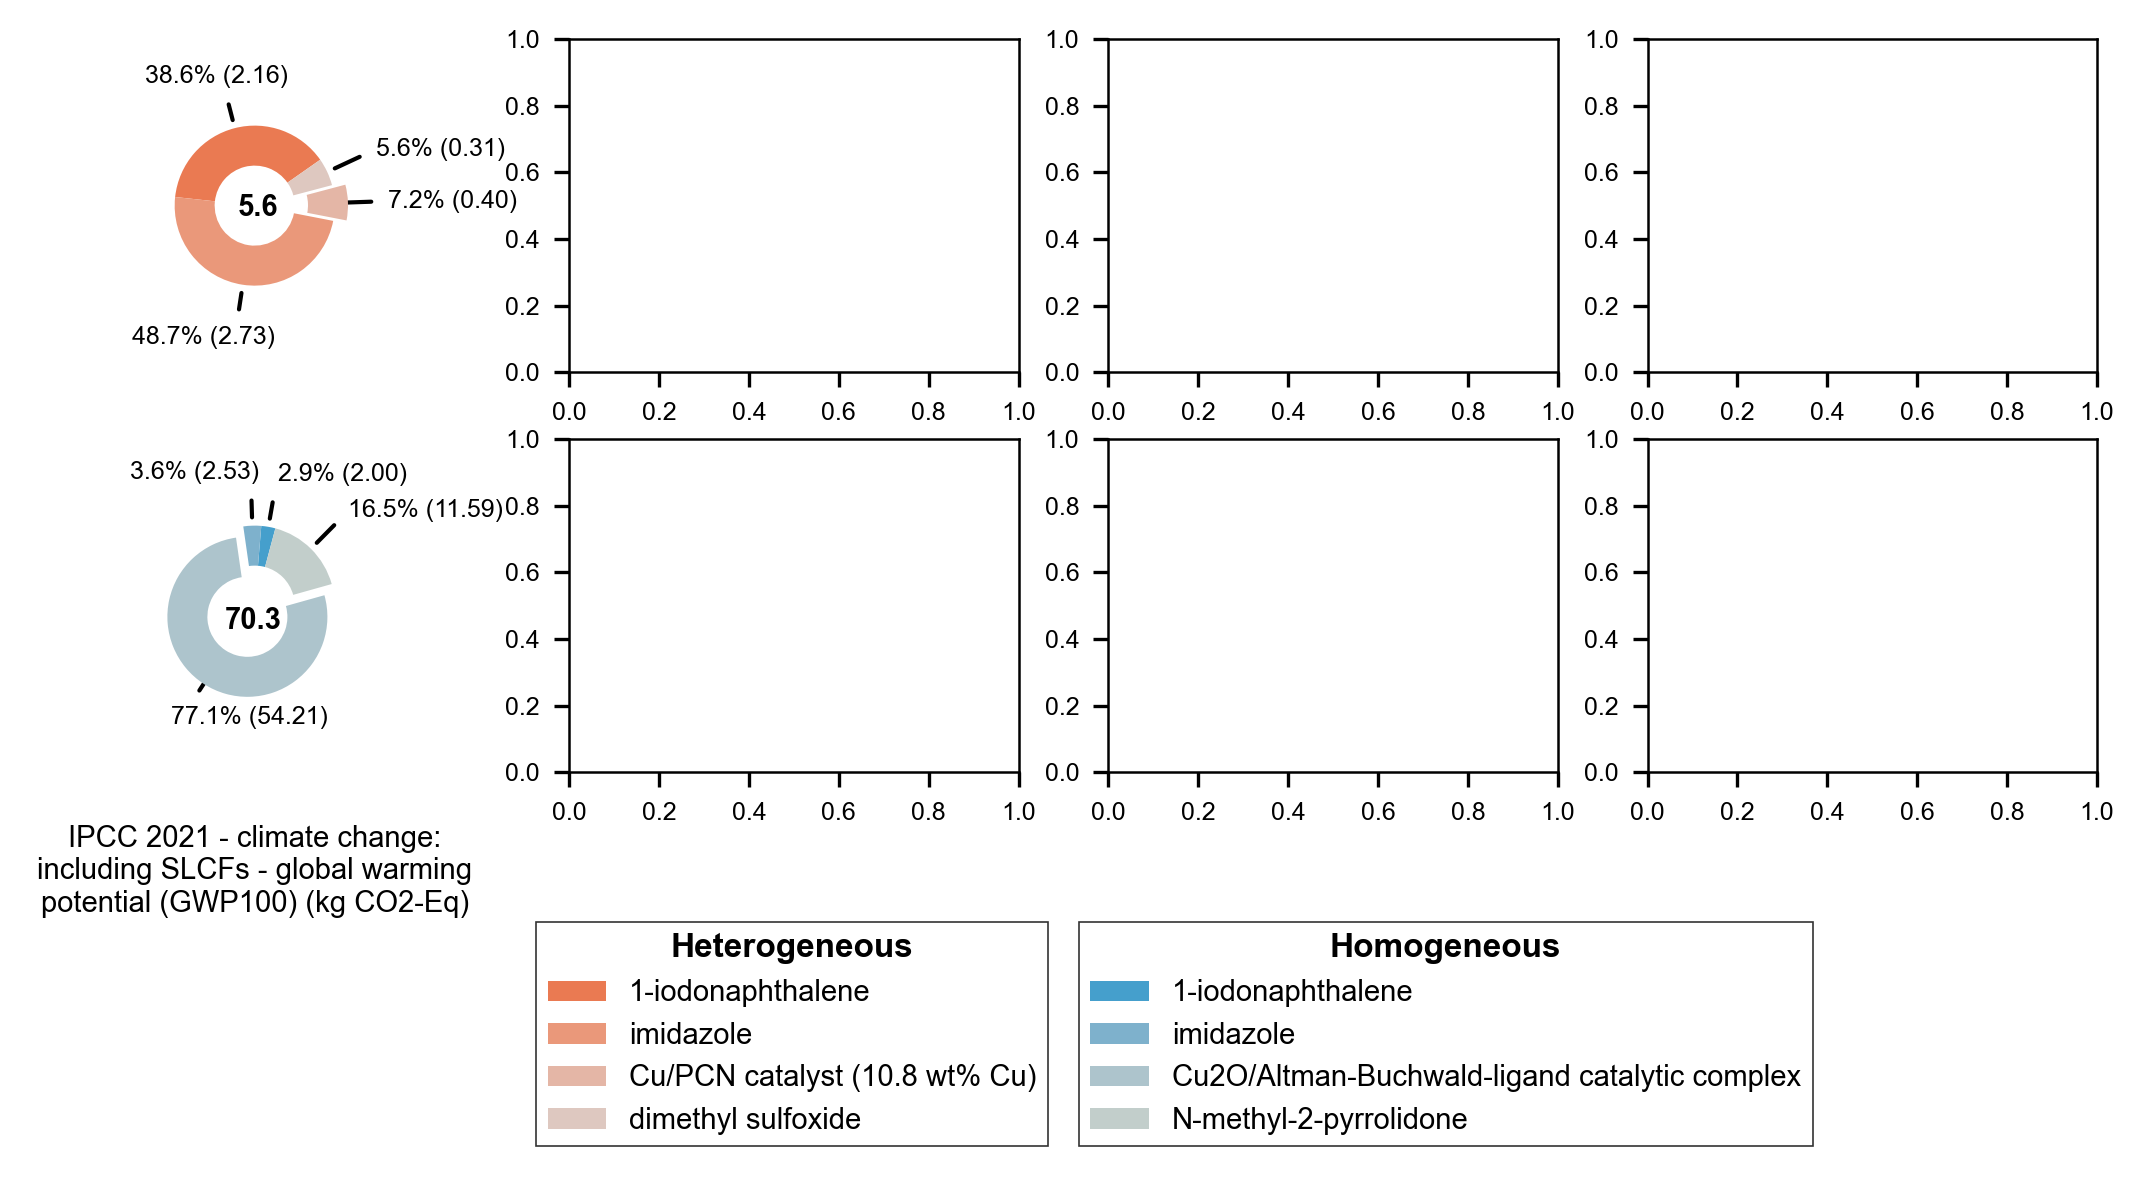

In [20]:
# Plot

# Figure specifications (fonts, sizes, figsize, etc.)
size_legend_font = 8
size_tick_font = 6
size_label_font = 7
mpl.rc("xtick", labelsize=size_tick_font)
mpl.rc("ytick", labelsize=size_tick_font)
mpl.rc("axes", labelsize=size_label_font, linewidth=0.6)
mpl.rc("font", family="Arial")
mpl.rc("mathtext", default="regular")
# mpl.rc('lines', )
# mpl.rc('markers', )
marker_style = dict(lw=0, marker="D", ms=1.5, mec="r", mfc="none", mew=0.7)

# Size of the figure
size_in_mm = (180, 100)  # input the desired size in mm (width, height)

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 2.5  # in mm
from_right = 2.5  # in mm
from_bottom = 2.5  # in mm
from_top = 2.5  # in mm

fig = plt.figure(
    figsize=[x / 25.4 for x in size_in_mm],
    dpi=300,
    #  tight_layout = {'pad': 0}
)

gs = fig.add_gridspec(
    nrows=3,
    ncols=1,
    # width_ratios=[1, 1, 1, 1],
    height_ratios=[1, 0.1, 0.25],
    # wspace=0.2,
    hspace=0.2,
    top=1 - from_top / size_in_mm[1],
    bottom=from_bottom / size_in_mm[1],
    left=from_left / size_in_mm[0],
    right=1 - from_right / size_in_mm[0],
)

doughnut = gs[0].subgridspec(
    nrows=2,
    ncols=4,
    width_ratios=[1, 1, 1, 1],
    height_ratios=[1, 1],
    wspace=0.2,
    hspace=0.2,
)

category = gs[1].subgridspec(
    nrows=1,
    ncols=4,
    width_ratios=[1, 1, 1, 1],
    wspace=0.2,
)

legend_gs = gs[2].subgridspec(
    nrows=1,
    ncols=2,
    wspace=0.001,
)

ax0 = fig.add_subplot(doughnut[0])
ax1 = fig.add_subplot(doughnut[1])
ax2 = fig.add_subplot(doughnut[2])
ax3 = fig.add_subplot(doughnut[3])
ax4 = fig.add_subplot(doughnut[4])
ax5 = fig.add_subplot(doughnut[5])
ax6 = fig.add_subplot(doughnut[6])
ax7 = fig.add_subplot(doughnut[7])

ax_label0 = fig.add_subplot(category[0])
ax_label0.axis("off")
ax_label1 = fig.add_subplot(category[1])
ax_label1.axis("off")
ax_label2 = fig.add_subplot(category[2])
ax_label2.axis("off")
ax_label3 = fig.add_subplot(category[3])
ax_label3.axis("off")
ax_legend0 = fig.add_subplot(legend_gs[0])
ax_legend0.axis("off")
ax_legend1 = fig.add_subplot(legend_gs[1])
ax_legend1.axis("off")

## DOUGHNUT CHARTS ################################################################
## GWP
w_hetero, t_hetero = plot_doughnut(
    ax=ax0,
    data=data_hetero,
    explode=explode_hetero,
    colors=hetero_colors,
    startangle=35,
    tot_loc = (0.45, 0.47)
)
w_homoge, t_homoge = plot_doughnut(
    ax=ax4,
    data=data_homoge,
    explode=explode_homoge,
    colors=homoge_colors,
    startangle=75,
    tot_loc = (0.41, 0.43)
)

ax_label0.text(
    x=0.5,
    y=0.0,
    s=category_label,
    fontdict=dict(fontsize=size_label_font, fontweight="normal"),
    horizontalalignment="center",
)

## LEGEND ################################################################
leg0 = ax_legend0.legend(w_hetero, labels_hetero,   
        loc="lower right",
        frameon=True,
        fancybox=False,
        edgecolor="k",
        # columnspacing=0.7,
        fontsize=7,
        title_fontsize=8,
        bbox_to_anchor=(1, 0))
leg0.get_frame().set_linewidth(0.4)
leg0.set_title(title="Heterogeneous", prop={"size":8, "weight":"bold"})

leg1 = ax_legend1.legend(w_homoge, labels_homoge,
        loc="lower left",
        frameon=True,
        fancybox=False,
        edgecolor="k",
        # columnspacing=0.7,
        fontsize=7,
        title_fontsize=8,
        bbox_to_anchor=(0, 0))
leg1.get_frame().set_linewidth(0.4)
leg1.set_title(title="Homogeneous", prop={"size":8, "weight":"bold"})

## EXPORT ################################################################
# figNamePNG = "LCAscore_total_barplot.png"
# figNameSVG = "LCAscore_total_barplot.svg"

# plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
# plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg
